In [25]:
#!pip install tensorflow librosa

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JorgeRuizDev/SpotMyFM/blob/main/Ludwig/notebooks/gtzan/gtzan_demo_train.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/JorgeRuizDev/SpotMyFM/blob/main/Ludwig/notebooks/gtzan/gtzan_demo_train.ipynb)

In [26]:
# Imports
import tensorflow as tf
from tensorflow.python.keras.api import keras
from tensorflow.python.keras.api.keras.preprocessing.image import ImageDataGenerator

import os
from pathlib import Path
from IPython.core.display import HTML, display

import librosa
import random
import numpy as np
from math import floor
from typing import Union, Any

In [27]:
def download():
  #!pip install kaggle
  import os
  os.environ['KAGGLE_USERNAME'] = "jorgeruizdev"
  os.environ['KAGGLE_KEY'] = "5f3badd86b1d1035e2723792a67a2879"
  !kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
  !unzip -qq /content/gtzan-dataset-music-genre-classification.zip
#download()

In [28]:
print(tf. __version__)
print(tf.config.list_physical_devices('GPU'))


2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
# CONFIG

SAMPLE_RATE = 22050

TRACK_LENGTH = 30

TRACK_SAMPLES = 22050 * TRACK_LENGTH

SPLITS = 10

SAMPLES_PER_SPLIT = TRACK_SAMPLES // SPLITS

N_MELS = 64

print(f"Samples Per Split {SAMPLES_PER_SPLIT}")

# Dataset:
DATASET_PATH = "/content/Data"

GENRES_PATH = f"{DATASET_PATH}/genres_original"

GENRES = os.listdir(GENRES_PATH)



# Training
BATCH_SIZE = 20


Samples Per Split 66150


In [30]:
GENRE_2_LABEL = {k: v for v, k in enumerate(GENRES)}
LABEL_2_GENRE = {v: k for k,v in GENRE_2_LABEL.items()}
print(f"Genre to Label Dict: {GENRE_2_LABEL}")
print(f"Label to Genre Dict: {LABEL_2_GENRE}")

Genre to Label Dict: {'classical': 0, 'jazz': 1, 'hiphop': 2, 'pop': 3, 'rock': 4, 'disco': 5, 'blues': 6, 'metal': 7, 'country': 8, 'reggae': 9}
Label to Genre Dict: {0: 'classical', 1: 'jazz', 2: 'hiphop', 3: 'pop', 4: 'rock', 5: 'disco', 6: 'blues', 7: 'metal', 8: 'country', 9: 'reggae'}


In [31]:
if not len(list(Path(f"{DATASET_PATH}/genres_original/disco").glob("*.wav"))) >= 100:
  print(f"""
    No subfolder 'genres_original/disco' found under {DATASET_PATH}.
    Please download the datasate from https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification and
    unzip it under {DATASET_PATH}.
  """)
  raise IOError


In [32]:
def split_track(y, samples_per_split = SAMPLES_PER_SPLIT):

    return [y[slice_samp:slice_samp + samples_per_split] for slice_samp in range(0, len(y), samples_per_split) ]



In [33]:
def normalize_mfccs(mfcc_feat: np.ndarray):
    return np.subtract(mfcc_feat,np.mean(mfcc_feat))


In [34]:
def preprocess_track(signal: Union[np.ndarray, Any], sr=SAMPLE_RATE):
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=N_MELS, sr=sr)

    #log_S = librosa.amplitude_to_db(mfccs)
    #delta = librosa.feature.delta(mfccs, order=1)

    return normalize_mfccs(mfccs)

In [35]:
def load_data(genre_path=GENRES_PATH):
    track_input = []
    labels = []
    for genre in GENRES:
        genre_folder = f"{genre_path}/{genre}"
        label = GENRE_2_LABEL[genre]
        for track in os.listdir(genre_folder):

            if (track == "jazz.00054.wav"):
                # This track is broken 
                continue

            y, sr = librosa.load(f"{genre_folder}/{track}", sr=SAMPLE_RATE)
            
            # Split into chunkso f SAMPLES_PER_SPLIT length 
            splits = split_track(y)

            track = []

            for split in splits:
                
                if (len(split) == SAMPLES_PER_SPLIT):
                    track.append(preprocess_track(split, sr))
            
            if len(track):  
                track_input.append(track)
                labels.append(label)

    

    return track_input, labels

In [36]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b), f"len(a) = {len(a)} != len(b) = {len(b)}"
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [37]:
tracks_, labels_ = load_data()

In [38]:
def train_test_val(ds, test=0.1, val=0.2):


    train_slice = floor(len(ds) * (1 - val + test))


    train = ds[:train_slice]
    rest = ds[train_slice:]

    rest_slice =  floor(len(rest) * (1 - (test / ( test + val))))

    test = rest[:rest_slice]
    val = rest[rest_slice:]

    return train, test, val


In [39]:
class TrackDataGen(keras.utils.Sequence):
    
    def __init__(self, data,
                 input_shape = (13, 259),
                 batch_size = 30):
        
        self.batch_size = batch_size
        self.shape = input_shape
        X = []
        Y = []

        for track_splits, labels in data:
            X.extend(track_splits)
            Y.extend(([labels]* len(track_splits)))

        X_np = np.array(X)
        X_np = np.expand_dims(X_np, axis=3)
        Y_np = np.array(Y)

        self.X, self.Y = unison_shuffled_copies(X_np, Y_np)
        
    
    
    def on_epoch_end(self):
        pass
    
    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size] 
        
        return batch_x, np.array(batch_y)
    
    def __len__(self):
        return len(self.X) // self.batch_size

In [40]:
class StopCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("accuracy") or 0) > 0.995:
            self.model.stop_training = True
stop_callback = StopCallback()

In [41]:
tracks, labels = tracks_, labels_


track_labels = list(zip(tracks, labels))

random.shuffle(track_labels)

train, test, val = train_test_val(track_labels)
print(len(train) + len(test) + len(val))


train_generator = TrackDataGen(train)
print(train_generator[0][0].shape)
validation_generator = TrackDataGen(val)




999
(30, 64, 130, 1)


In [42]:
from tensorflow.python.keras.layers.core import Dropout
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(32, (5,5), activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.MaxPooling2D(2, 2),                                       

    keras.layers.AveragePooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(256, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dense(10, activation='softmax'),  
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [43]:
history = model.fit(train_generator,
                     validation_data = validation_generator, 
                     #validation_steps = len(tracks) // BATCH_SIZE,
                     epochs=1000,
                     callbacks = [stop_callback]
                     )

Epoch 1/1000
299/299 [==============================] - 7s 21ms/step - loss: 1.7785 - accuracy: 0.3521 - val_loss: 1.4290 - val_accuracy: 0.5545
Epoch 2/1000
299/299 [==============================] - 6s 20ms/step - loss: 1.3237 - accuracy: 0.5263 - val_loss: 1.2187 - val_accuracy: 0.5364
Epoch 3/1000
299/299 [==============================] - 6s 20ms/step - loss: 1.0891 - accuracy: 0.6080 - val_loss: 1.0824 - val_accuracy: 0.6273
Epoch 4/1000
299/299 [==============================] - 6s 20ms/step - loss: 0.9505 - accuracy: 0.6680 - val_loss: 1.0608 - val_accuracy: 0.6364
Epoch 5/1000
299/299 [==============================] - 6s 20ms/step - loss: 0.8235 - accuracy: 0.7156 - val_loss: 1.4941 - val_accuracy: 0.5636
Epoch 6/1000
299/299 [==============================] - 6s 20ms/step - loss: 0.7377 - accuracy: 0.7472 - val_loss: 1.0732 - val_accuracy: 0.6273
Epoch 7/1000
299/299 [==============================] - 6s 20ms/step - loss: 0.6411 - accuracy: 0.7831 - val_loss: 1.1982 - val_ac

In [44]:

test_generator = TrackDataGen(test)
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

21/21 [==============================] - 0s 8ms/step - loss: 1.8656 - accuracy: 0.3349
test loss, test acc: [1.8656232357025146, 0.33492064476013184]


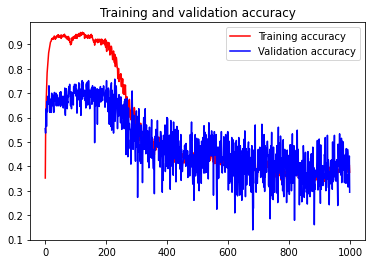

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
import requests
from IPython import display
url = input()
r = requests.get(url, allow_redirects=True)
open('test.mp3', 'wb').write(r.content)

Y, sr = librosa.load('test.mp3')

track = preprocess_track(Y, sr)

pred = model.predict(np.expand_dims([track], axis=3))
print(pred)
print(LABEL_2_GENRE.get(np.argmax(pred)))

display.Audio("test.mp3")